# Problem Set 5
## Nora Nickels
### Perspectives of Computational Analysis
### Winter 2018

## Problem 1: Multinomial logistic regression and cross validation

In [2]:
# Import packages

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [3]:
# Load the strongdrink data.

strongdrink = pd.read_csv("strongdrink.txt")
strongdrink['const'] = 1
strongdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### (a) Estimate multinomial logistic regression model 

In [4]:
# Check for missing values
strongdrink.isnull().sum()

cultivar      0
alco          0
malic         0
ash           0
alk           0
magn          0
tot_phen      0
flav          0
nonfl_phen    0
proanth       0
color_int     0
hue           0
OD280rat      0
proline       0
const         0
dtype: int64

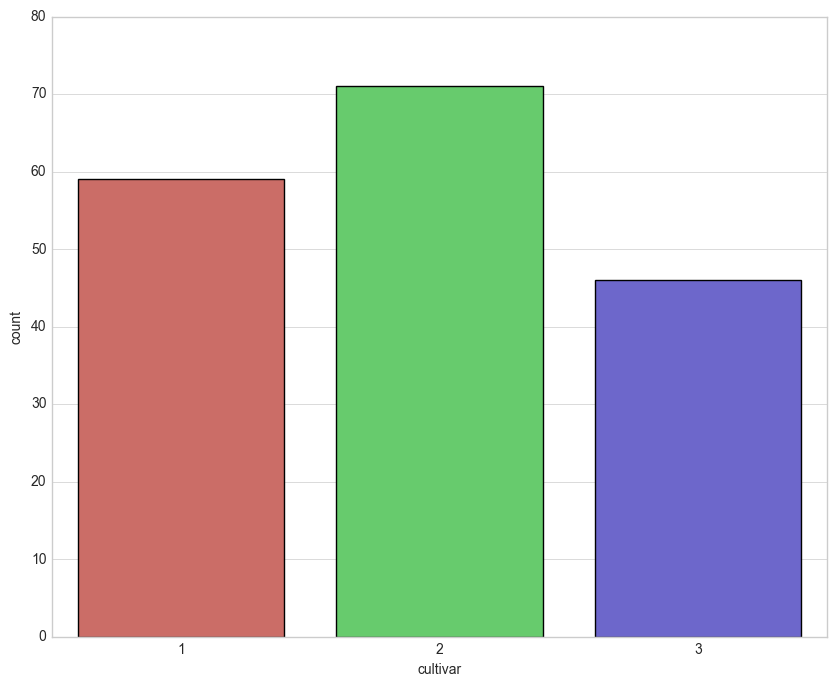

In [5]:
# Let's check how many categories in cultivar and how many observations in each category
sb.countplot(x='cultivar', data=strongdrink, palette='hls')

We want to predict which cultivar category based on alcohol, malic acid, total phenols, and color intensity. If we create a predictive model, we might be best at predicting cultivar 2, based on the bar chart above. The more data we have, the better we'll be at predicting, typically.

In [6]:
# Separate the data into a training set and test set 

X = strongdrink[['const', 'alco', 'malic', 'tot_phen', 'color_int']]
y = strongdrink[['cultivar']]

# This function train_test_split is from sklearn.cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state=20)

MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
MultLogReg.fit(X_train, y_train)

print(MultLogReg.coef_)

[[ -8.45998053e-06   1.70038994e+00  -2.65604001e-01   1.22389318e+00
    2.27585993e-02]
 [ -1.76923785e-05  -1.46805313e+00  -3.33053748e-01   6.64013944e-01
   -9.22712974e-01]
 [  2.61523590e-05  -2.32336811e-01   5.98657749e-01  -1.88790712e+00
    8.99954375e-01]]


/Users/noranickels/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The sets of estimated coefficients for each j category (1, 2, and 3) are the following, in that order:
* [ 1.70042716 -0.26560795  1.22389492  0.02275107]
* [-1.4680149  -0.33305177  0.66400724 -0.92271029]
* [-0.23241249  0.5986597  -1.88790219  0.89995922]

In [7]:
# Predict the three categories using this estimated model on the test set
y_pred = MultLogReg.predict(X_test)

In [8]:
# Report error rates.
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



The error rates for each cultivar are the following:
* Cultivar 1: error rate = 0.13
* Cultivar 2: error rate = 0
* Cultivar 3: error rate = 0

The model is best at predicting cultivar 2 and cultivar 3. Cultivar 2 is the category with the most observations, so the model is indeed most accurately predicting the category with the most observations (see bar chart above), but it is also best at accurately predicting the category with the least observations (cultivar 3).

### (b) Leave-one-out cross validation

In [9]:
# Define loo as a leave-one-out object, then
# split it into N different partitions

# Note that the LeaveOneOut() function does not work
# well with pandas DataFrames
Xvars = X.values
yvals = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_tests_loo = np.zeros(N_loo)
y_preds_loo = np.zeros(N_loo)

# This loop will take 20 or 30 seconds
for train_index, test_index in loo.split(Xvars):
    X_train_loo, X_test_loo = Xvars[train_index], Xvars[test_index]
    y_train_loo, y_test_loo = yvals[train_index], yvals[test_index]
    y_tests_loo[test_index] = y_test_loo
    MultLogReg_loo = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg_loo.fit(X_train_loo, y_train_loo)
    y_pred_loo = MultLogReg_loo.predict(X_test_loo)
    y_preds_loo[test_index] = y_pred_loo
    MSE_vec[test_index] = (y_test_loo - y_pred_loo) ** 2

/Users/noranickels/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
print(MultLogReg_loo.coef_)
print(classification_report(y_tests_loo, y_preds_loo))

[[  8.60900995e-07   1.56221688e+00  -1.37629195e-01   1.55187408e+00
    1.16456614e-01]
 [  5.52106896e-07  -1.39397151e+00  -5.09918055e-01   4.96242105e-01
   -1.14498163e+00]
 [ -1.41300788e-06  -1.68245366e-01   6.47547249e-01  -2.04811618e+00
    1.02852502e+00]]
             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



The error rates for LOOCV for each cultivar are the following:
* Cultivar 1: error rate = 0.10
* Cultivar 2: error rate = 0.09
* Cultivar 3: error rate = 0.04

The model is best at predicting cultivar 3. Cultivar 3 is the category with the least observations. When compared to the error rates from part a, overall, these error rates are worse. The error rate did decrease for cultivar 1, but increased (worse precision) for cultivars 1 and 2.

In [11]:
# Report LOOCV estimate for the test MSE as the average MSE 

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.0965909090909 , test estimate MSE standard err= 0.394262505894


The LOOCV estimate for the test MSE, reported as the average MSE, is 0.0965909090909.

### (c) K-fold cross validation

In [12]:
k = 3
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train_k, X_test_k = Xvars[train_index], Xvars[test_index]
    y_train_k, y_test_k = yvals[train_index], yvals[test_index]
    MultLogReg_k = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg_k.fit(X_train_k, y_train_k)
    y_pred_k = MultLogReg_k.predict(X_test_k)
    MSE_vec_kf[k_ind] = ((y_test_k - y_pred_k) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

k index= 0
MSE for test set 0  is 1.09135305947
k index= 1
MSE for test set 1  is 1.35420856076
k index= 2
MSE for test set 2  is 1.161117717


/Users/noranickels/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
print(MultLogReg_k.coef_)
print(classification_report(y_test_k, y_pred_k))

[[  3.34787441e-05   1.66782377e+00  -6.13535949e-02   1.52529385e+00
   -1.13721612e-02]
 [ -6.22273292e-08  -1.55237447e+00  -5.48330289e-01   2.54276152e-01
   -8.00001498e-01]
 [ -3.34165167e-05  -1.15449305e-01   6.09683884e-01  -1.77957000e+00
    8.11373659e-01]]
             precision    recall  f1-score   support

          1       0.83      1.00      0.91        20
          2       1.00      0.84      0.91        25
          3       1.00      1.00      1.00        13

avg / total       0.94      0.93      0.93        58



The error rates for k-fold cross validation for each cultivar are the following:
* Cultivar 1: error rate = 0.17
* Cultivar 2: error rate = 0
* Cultivar 3: error rate = 0

The model is best at predicting cultivar 2 and cultivar 3. Compared to part a, these error rates are back to perfect, like in part a. They are improved when compared to part b. The error rate for cultivar 1, however, is the worst when compared to both part a and part b. 

In [14]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 1.20222644574 test estimate MSE standard err= 0.111177633614


The LOOCV estimate for the test MSE, reported as the average MSE, is 1.20222644574.

## Problem 2: Splines and interpolation

In [15]:
# Import needed packages

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
sb.set_style('whitegrid')

In [16]:
# Load the CoolIndex data.

CoolIndex = pd.read_csv("CoolIndex.txt")
CoolIndex.rename(columns={'1.100000000000000000e+01': 'age'}, inplace=True)
CoolIndex.rename(columns={'1.098160218403766208e+01': 'coolness'}, inplace=True)
CoolIndex.head()

,age,coolness
0,11.0,11.364925
1,11.0,10.190227
2,11.0,9.903725
3,11.0,8.997918
4,11.0,9.882644


### (a) Create a scatterplot

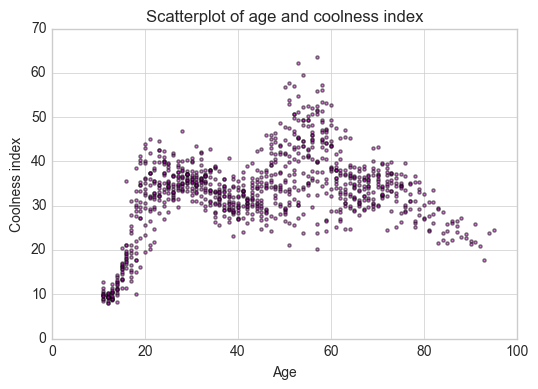

In [18]:
# Create scatterplot of the data
age = CoolIndex['age']
coolness = CoolIndex['coolness']

plt.scatter(age, coolness, s = 5, c = 'm', alpha = 0.5)
plt.xlabel(r'Age')
plt.ylabel(r'Coolness index')
plt.title('Scatterplot of age and coolness index')
plt.show()

### (b) Use OLS regression to fit a stepwise function to these data

In [19]:
coolness = CoolIndex['coolness']
age = CoolIndex['age']
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = (age >= 77).astype(int)

X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,955.000000,955.000000,955.000000,955.000000,955.000000
mean,0.161257,0.276440,0.285864,0.217801,0.058639
std,0.367960,0.447471,0.452062,0.412968,0.235070
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
reg_step = sm.OLS(endog=coolness, exog=X_step, missing='drop')
reg_step_results = reg_step.fit()
print(reg_step_results.summary())
y_step_pred = reg_step_results.predict(X_step)

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.36e-113
Time:                        19:18:49   Log-Likelihood:                -3210.8
No. Observations:                 955   AIC:                             6432.
Df Residuals:                     950   BIC:                             6456.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
age_bin1      20.1617      0.564     35.748      0.0

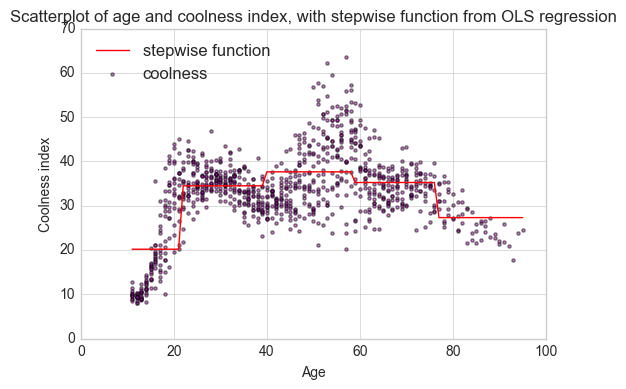

In [21]:
plt.scatter(age, coolness, s = 5, c = 'm', alpha = 0.5)
plt.plot(CoolIndex.age, y_step_pred, color = 'r', label='stepwise function')
plt.xlabel(r'Age')
plt.ylabel(r'Coolness index')
plt.title('Scatterplot of age and coolness index, with stepwise function from OLS regression')
plt.legend(loc='upper left')
plt.show()

In [22]:
print(reg_step_results.params)

age_bin1    20.161684
age_bin2    34.475788
age_bin3    37.635105
age_bin4    35.225400
age_bin5    27.296378
dtype: float64


The estimated step function values for each bin are:
* age_bin1 = 20.161684
* age_bin2 = 34.475788
* age_bin3 = 37.635105
* age_bin4 = 35.225400
* age_bin5 = 27.296378

In [23]:
print(reg_step_results.params[3])

35.2254000402


The predicted coolness of a 73-year old from the stepwise function is 35.2254000402

### (c) Linear spline (continous)

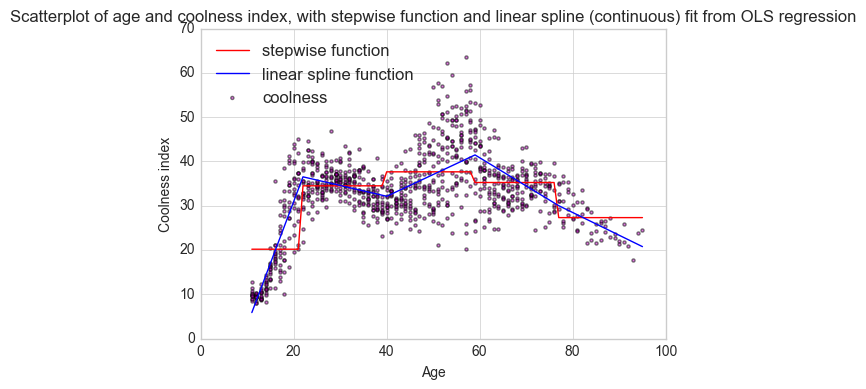

In [24]:
from scipy.interpolate import LSQUnivariateSpline

knots = [22, 40, 59, 77]
spl_cool = LSQUnivariateSpline(age.values, coolness.values, knots, k=1)

# age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(age, coolness, s = 5, c = 'm', alpha = 0.5)
plt.plot(CoolIndex.age, y_step_pred, color = 'r', label='stepwise function')
plt.plot(CoolIndex.age, spl_cool(CoolIndex.age), 'b-', label='linear spline function')
plt.xlabel(r'Age')
plt.ylabel(r'Coolness index')
plt.title('Scatterplot of age and coolness index, with stepwise function and linear spline (continuous) fit from OLS regression')
plt.legend(loc='upper left')
plt.show()

In [25]:
age_for_predict = np.array([73])
predicted_coolness = spl_cool(age_for_predict)
print('Age=', age_for_predict)
print('Predicted coolness=', predicted_coolness)

Age= [73]
Predicted coolness= [ 32.53661813]


The predicted coolness of a 73-year old from the linear spline is 32.53661813.

### (d) Cubic spline (continous)

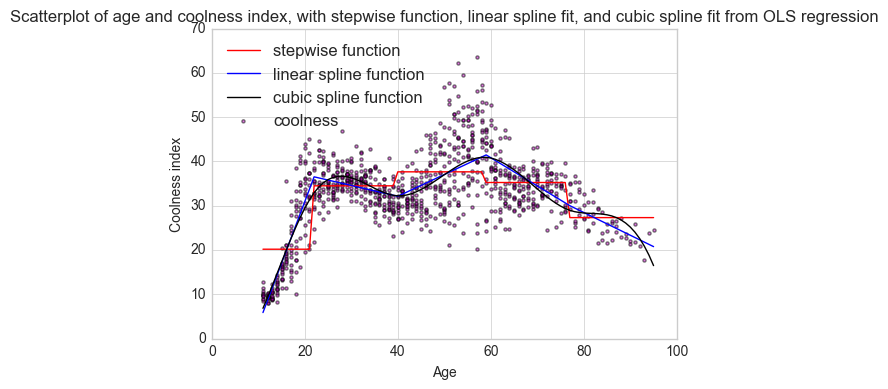

In [26]:
from scipy.interpolate import LSQUnivariateSpline

knots = [22, 40, 59, 77]
spl_cubic_cool = LSQUnivariateSpline(age.values, coolness.values, knots, k=3)

# age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(age, coolness, s = 5, c = 'm', alpha = 0.5)
plt.plot(CoolIndex.age, y_step_pred, color = 'r', label='stepwise function')
plt.plot(CoolIndex.age, spl_cool(CoolIndex.age), 'b-', label='linear spline function')
plt.plot(CoolIndex.age, spl_cubic_cool(CoolIndex.age), 'k-', label='cubic spline function')
plt.xlabel(r'Age')
plt.ylabel(r'Coolness index')
plt.title('Scatterplot of age and coolness index, with stepwise function, linear spline fit, and cubic spline fit from OLS regression')
plt.legend(loc='upper left')
plt.show()

In [27]:
age_for_predict = np.array([73])
predicted_coolness = spl_cubic_cool(age_for_predict)
print('Age=', age_for_predict)
print('Predicted coolness=', predicted_coolness)

Age= [73]
Predicted coolness= [ 31.26499395]


The predicted coolness of a 73-year old from the linear spline is 31.26499395.